## Data Preprocessing

In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

IMG_SIZE = (64, 64)

def show(img):
    plt.imshow(img)
    plt.show()

def remove_lines(img):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([50, 50, 50])  # Adjust as needed based on line intensity
    mask = cv2.inRange(img, lower_black, upper_black)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_inpainted = cv2.inpaint(gray, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return img_inpainted

def crop(img):
    _, thresh = cv2.threshold(img, 240, 255, cv2.THRESH_BINARY_INV) 
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_image = img[y:y+h, x:x+w]
    return cropped_image

def segment_save(img, filename, destination_path):
    captcha_contents = filename.split('-')[0]
    chars = list(captcha_contents)
    for char in chars:
        class_path = os.path.join(destination_path, char)
        if not os.path.exists(class_path):
            os.makedirs(class_path)
    height, width = img.shape
    num_portions = len(chars)
    portion_width = width // num_portions

    for i in range(num_portions):
        # Segment
        x_start = i * portion_width
        x_end = x_start + portion_width
        portion = img[:, x_start:x_end]

        # Resize (keras will do it for us apparently)
        portion = cv2.resize(portion, IMG_SIZE, interpolation=cv2.INTER_AREA)

        # Threshold the image to make sure everything is black and white
        _, portion = cv2.threshold(portion, 240, 255, cv2.THRESH_BINARY_INV)

        # Save
        char_filename = f"{chars[i]}/{chars[i]}_0.png"
        char_filepath = os.path.join(destination_path, char_filename)
        counter = 0
        while os.path.exists(char_filepath):
            char_filename = f"{chars[i]}/{chars[i]}_{counter}.png"
            char_filepath = os.path.join(destination_path, char_filename)
            counter += 1
        cv2.imwrite(char_filepath, portion)

def print_char_stats(chars_path):
    classes = os.listdir(chars_path)

    # Initialize a counter to track the occurrences of each character
    character_counter = Counter()

    # Loop through each file in the folder
    for folder in classes:
        for char in folder:
            # Make sure the file is a valid image (you can adjust the file extension if needed)
            if char.endswith('.png'):
                # Extract the character label from the filename (assuming filename format like 'a_1.png')
                character_label = char.split('_')[0]  # Adjust based on your filename format

                # Update the counter with the extracted character label
                character_counter[character_label] += 1

    # Total number of characters (images)
    total_characters = sum(character_counter.values())

    # Number of unique classes (characters)
    num_classes = len(classes)

    # Print statistics
    print(f"Total number of characters: {total_characters}")
    print(f"Number of unique classes (characters): {num_classes}")
    print("\nCharacter distribution:")
    for character, count in character_counter.items():
        print(f"Character '{character}': {count} instances")
    
    return num_classes

In [5]:
folder_path = "./dataset/" #change this to your dataset folder
main_path = folder_path + "main/"
train_path = folder_path + "train/"
test_path = folder_path + "test/"
train_chars_path = folder_path + "train_chars/"
test_chars_path = folder_path + "test_chars/"

In [10]:
# # Segment captchas in training data and save to folder
# if not os.path.exists(train_chars_path):
#     os.makedirs(train_chars_path)

# data_files = os.listdir(train_path)
    
# for filename in data_files:
#     img = cv2.imread(os.path.join(train_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, train_chars_path)

# # Print Stats
# num_classes = print_char_stats(train_chars_path)

# # Segment captchas in test data and save to folder
# if not os.path.exists(test_chars_path):
#     os.makedirs(test_chars_path)

# data_files = os.listdir(test_path)
    
# for filename in data_files:
#     img = cv2.imread(os.path.join(test_path, filename))
#     img = remove_lines(img)
#     img = crop(img)
#     segment_save(img, filename, test_chars_path)


## Augmenting Dataset

## Model

#### Initialise Model

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
# Init data
train_data = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # fill_mode='nearest',
    # width_shift_range=0.2, 
    # height_shift_range=0.2,
    # zoom_range=0.3
)

test_data = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

batch_size = 32

train_generator = train_data.flow_from_directory(
    train_chars_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_data.flow_from_directory(
    test_chars_path,
    target_size=IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 48007 images belonging to 36 classes.
Found 12010 images belonging to 36 classes.


In [7]:
# Bare bones version
num_classes = 36
input_shape = (64, 64, 1)
model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # 2nd Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # 3rd Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Conv2D(128, (1, 1), activation='relu'),
    # BatchNormalization(),
    # MaxPooling2D(pool_size=(2, 2)),
    # Dropout(0.25),
    
    # Fully Connected Block
    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.compile(
    optimizer=optimizer, 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 64)       2

#### Training Model

In [14]:
epochs = 100
history = model.fit(
    train_generator, 
    epochs=epochs, 
    validation_data=test_generator,
    callbacks=early_stopping
)
model.save('captcha-model.keras')

Epoch 1/100
1501/1501 [==============================] - 108s 71ms/step - loss: 3.5184 - accuracy: 0.0781 - val_loss: 2.6824 - val_accuracy: 0.2690
Epoch 2/100
1501/1501 [==============================] - 103s 69ms/step - loss: 2.8785 - accuracy: 0.1993 - val_loss: 1.9583 - val_accuracy: 0.4531
Epoch 3/100
1501/1501 [==============================] - 103s 69ms/step - loss: 2.6114 - accuracy: 0.2668 - val_loss: 1.7605 - val_accuracy: 0.4903
Epoch 4/100
1501/1501 [==============================] - 101s 67ms/step - loss: 2.4670 - accuracy: 0.2998 - val_loss: 1.5458 - val_accuracy: 0.5559
Epoch 5/100
1501/1501 [==============================] - 102s 68ms/step - loss: 2.3861 - accuracy: 0.3234 - val_loss: 1.5068 - val_accuracy: 0.5684
Epoch 6/100
1501/1501 [==============================] - 99s 66ms/step - loss: 2.3187 - accuracy: 0.3437 - val_loss: 1.4398 - val_accuracy: 0.5923
Epoch 7/100
1501/1501 [==============================] - 102s 68ms/step - loss: 2.2844 - accuracy: 0.3528 - val_l

#### Evaluation

In [15]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Add more eval metrics here: captcha accuracy

376/376 [==============================] - 7s 17ms/step - loss: 1.0173 - accuracy: 0.7171
Test Accuracy: 71.71%


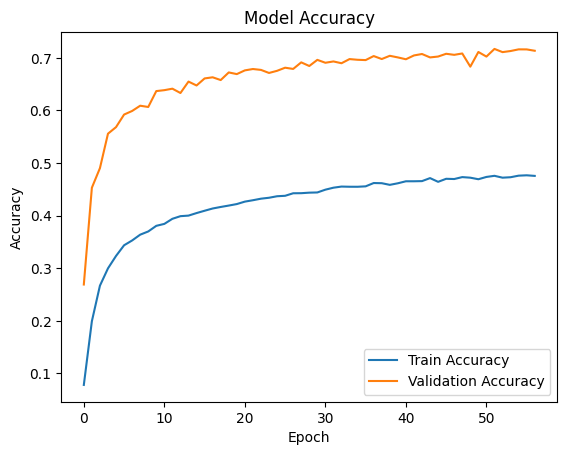

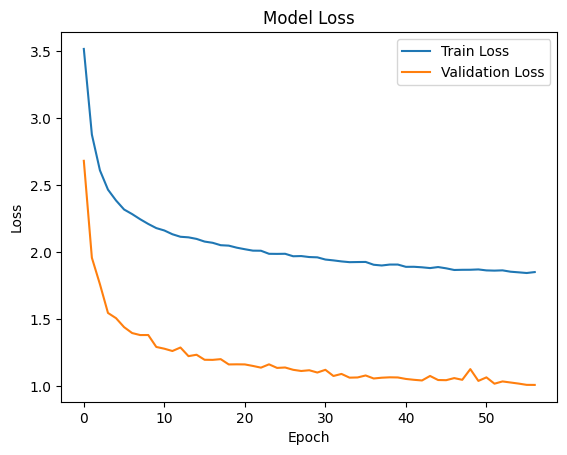

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [ ]:
# Grad-CAM

